In [6]:
import pandas as pd
import numpy as np
import random
from collections import defaultdict, Counter
import os
import glob
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, average_precision_score, precision_score
from xgboost import XGBClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
import gseapy as gp
import obonet
import networkx as nx
import random
import math
import time
from adjustText import adjust_text
import pickle
import statsmodels.api as sm
import statsmodels.formula.api as smf


pd.set_option('display.max_columns', 50) 

In [ ]:
folder_path = '/andes-benchmark-data/mod/' # embedings who only have genes that are interesected with all the other embedings

subfolders = [f.path for f in os.scandir(folder_path) if f.is_dir()]
#subfolders = subfolders[:3]  

# dict of embeddings and gene list 
embeddings = {}
gene_lists = {}

for subfolder in subfolders:
    print(f"Processing subfolder: {subfolder}")
    gene_txt_files = glob.glob(os.path.join(subfolder, '*.txt'))
    if not gene_txt_files:
        print(f"No txt file found in {subfolder}")
        continue
    gene_file = gene_txt_files[0]
    with open(gene_file, 'r') as f:
        genes = [line.strip() for line in f]
    gene_lists[subfolder] = genes

    csv_files = glob.glob(os.path.join(subfolder, '*.csv'))
    if not csv_files:
        print(f"No csv file found in {subfolder}")
        continue
    csv_file = csv_files[0]
    embedding = pd.read_csv(csv_file, header=None)
    embeddings[subfolder] = embedding

In [9]:
reference_subfolder = list(gene_lists.keys())[0]
reference_genes = gene_lists[reference_subfolder]  # get an order of genes that the others will follow
reference_node2index = {x: i for i, x in enumerate(reference_genes)}

reindexed_embeddings = {}

for subfolder in gene_lists:
    assert set(gene_lists[subfolder]) == set(reference_genes), "All embeddings must have the same gene set."
    
    current_genes = gene_lists[subfolder]
    gene_to_idx = {g: i for i, g in enumerate(current_genes)}
    
    emb = embeddings[subfolder]
    reorder_indices = [gene_to_idx[g] for g in reference_genes]
    
    ordered_emb = emb.iloc[reorder_indices].copy()
    ordered_emb.index = reference_genes  
    
    reindexed_embeddings[subfolder] = ordered_emb



In [10]:
doid_direct = gp.read_gmt("/omim.20231030.direct.gmt")
doid_prop = gp.read_gmt("/omim.20231030.prop.gmt")

In [11]:
doid_direct = {term: [gene for gene in genes if gene in reference_genes] for term, genes in doid_direct.items()}
doid_prop = {term: [gene for gene in genes if gene in reference_genes] for term, genes in doid_prop.items()}

doid_direct = {term: genes for term, genes in doid_direct.items() if genes}
doid_prop = {term: genes for term, genes in doid_prop.items() if genes}


In [12]:
file_path = "/grain/rad4/onto/out/doid_agr_slim.txt"

doid_slim = pd.read_csv(file_path, sep='\t', header=0, names=["doid", "name"])
slim_set = set(doid_slim['doid'].tolist())

doid_slim

,doid,name
0,DOID:0050155,sensory system disease
1,DOID:0050177,monogenic disease
2,DOID:0060071,pre-malignant neoplasm
3,DOID:0060072,benign neoplasm
4,DOID:0060118,thoracic disease
5,DOID:0080014,chromosomal disease
6,DOID:0080015,physical disorder
7,DOID:0080577,polygenic disease
8,DOID:104,bacterial infectious disease
9,DOID:1287,cardiovascular system disease


In [34]:
doid_prop_20 = [doid for doid, gene_list in doid_prop.items() if len(gene_list) >= 20]

doid_use = list(set(doid_prop_20))
len(doid_use)


141

In [31]:
graph = obonet.read_obo("/doid.obo")

# dict of slim to all the things that propogate to slim 
slim_ancestors = {}

for slim in slim_set:
    if slim not in graph:
        print(slim)
        continue
    ancestors = nx.ancestors(graph, slim) 
    
    slim_ancestors[slim] = ancestors

In [35]:
doid_to_slim = {}

for term in doid_use:
    matching_keys = [key for key, values in slim_ancestors.items() if term in values]
    doid_to_slim[term] = matching_keys

doid_to_slim

filtered_doid_to_slim = {term: matches for term, matches in doid_to_slim.items() if matches}
filt_slim_to_doid = defaultdict(list)

for term, matches in filtered_doid_to_slim.items():
    for match in matches:
        filt_slim_to_doid[match].append(term)

print(len(filt_slim_to_doid.keys()))
len(filtered_doid_to_slim)

20


103

In [77]:
doid_use = []  
filtered_filt_slim_to_doid = {}  

for match, terms in filt_slim_to_doid.items():
    available_terms = [term for term in terms if term not in doid_use]
    #print(len(available_terms))
    
    selected_terms = available_terms #available_terms[:3]
    doid_use.extend(selected_terms)
    
    filtered_filt_slim_to_doid[match] = selected_terms

    
print(len(doid_use))

103


In [78]:
doid_prop_use = {term: genes for term, genes in doid_prop.items() if term in doid_use}
doid_slim_use = {term: genes for term, genes in doid_prop.items() if term in slim_set}


In [80]:
random.seed(42)

holdout_dict = {}
cv_fold1_dict = {}
cv_fold2_dict = {}
cv_fold3_dict = {}

for doid_term in list(doid_prop_use):
    pos_genes = set(doid_prop_use[doid_term])
    pos_count = len(pos_genes)

    # Get non-negative set (from the propagated slim)
    non_neg_list = []
    for slim in doid_to_slim[doid_term]:
        non_neg_list.extend(doid_slim_use[slim])
    non_neg_list = set(non_neg_list)

    all_values = [value for values in doid_slim_use.values() for value in values]
    all_values = set(all_values)

    # Negative genes (candidate pool)
    neg_genes = all_values - pos_genes - non_neg_list

    # Number of negatives we want to sample
    neg_needed = 10 * pos_count

    # Identify associated and other slim terms
    associated_slims = set(doid_to_slim[doid_term])
    all_slim_terms = set(doid_slim_use.keys())
    other_slims = all_slim_terms - associated_slims

    chosen_negatives = set()

    if len(other_slims) > 0:
        neg_per_slim = neg_needed // len(other_slims)

        for slim_term in other_slims:
            candidate_genes = list(neg_genes.intersection(doid_slim_use[slim_term]))
            alloc_count = min(neg_per_slim, len(candidate_genes))
            chosen = random.sample(candidate_genes, alloc_count) if alloc_count > 0 else []
            chosen_negatives.update(chosen)

        # Check if we still need more negatives (due to flooring or some slims not having enough)
        allocated_count = len(chosen_negatives)
        if allocated_count < neg_needed:
            remainder = neg_needed - allocated_count
            remaining_candidates = list(neg_genes - chosen_negatives)
            if remainder > len(remaining_candidates):
                remainder = len(remaining_candidates)
            if remainder > 0:
                chosen_negatives.update(random.sample(remaining_candidates, remainder))
    else:
        chosen_negatives = set(random.sample(neg_genes, min(neg_needed, len(neg_genes))))
    
    pos_list = list(pos_genes)
    neg_list = list(chosen_negatives)
    random.shuffle(pos_list)
    random.shuffle(neg_list)
    
    holdout_pos_count = max(1, int(0.2 * len(pos_list))) if len(pos_list) > 0 else 0
    holdout_neg_count = max(1, int(0.2 * len(neg_list))) if len(neg_list) > 0 else 0
    
    holdout_pos = pos_list[:holdout_pos_count]
    holdout_neg = neg_list[:holdout_neg_count]
    
    train_pos = pos_list[holdout_pos_count:]
    train_neg = neg_list[holdout_neg_count:]
    
    def split_into_folds(items, n_folds=3):
        fold_size = len(items) // n_folds
        folds = []
        start = 0
        for i in range(n_folds):
            extra = 1 if i < (len(items) % n_folds) else 0
            end = start + fold_size + extra
            folds.append(items[start:end])
            start = end
        return folds
    
    pos_folds = split_into_folds(train_pos, 3)
    neg_folds = split_into_folds(train_neg, 3)
        
    holdout_data = [{"gene": g, "result": 1} for g in holdout_pos] + \
                   [{"gene": g, "result": 0} for g in holdout_neg]
    holdout_df = pd.DataFrame(holdout_data)
    
    fold_dfs = []
    for i in range(3):
        fold_data = [{"gene": g, "result": 1} for g in pos_folds[i]] + \
                    [{"gene": g, "result": 0} for g in neg_folds[i]]
        fold_df = pd.DataFrame(fold_data)
        fold_dfs.append(fold_df)
    
    holdout_dict[doid_term] = holdout_df
    cv_fold1_dict[doid_term] = fold_dfs[0]
    cv_fold2_dict[doid_term] = fold_dfs[1]
    cv_fold3_dict[doid_term] = fold_dfs[2]


In [ ]:
for doid_term in holdout_dict.keys():
    holdout_pos = (holdout_dict[doid_term]['result'] == 1).sum()
    holdout_neg = (holdout_dict[doid_term]['result'] == 0).sum()
    
    fold1_pos = (cv_fold1_dict[doid_term]['result'] == 1).sum()
    fold1_neg = (cv_fold1_dict[doid_term]['result'] == 0).sum()
    
    fold2_pos = (cv_fold2_dict[doid_term]['result'] == 1).sum()
    fold2_neg = (cv_fold2_dict[doid_term]['result'] == 0).sum()
    
    fold3_pos = (cv_fold3_dict[doid_term]['result'] == 1).sum()
    fold3_neg = (cv_fold3_dict[doid_term]['result'] == 0).sum()
    
    print(
        f"{doid_term}: "
        f"Holdout(Pos={holdout_pos}, Neg={holdout_neg}) | "
        f"Fold1(Pos={fold1_pos}, Neg={fold1_neg}) | "
        f"Fold2(Pos={fold2_pos}, Neg={fold2_neg}) | "
        f"Fold3(Pos={fold3_pos}, Neg={fold3_neg})"
    )


In [ ]:
file_names = ["omim_cv_fold1_dict.pkl", "omim_cv_fold2_dict.pkl", "omim_cv_fold3_dict.pkl", "omim_holdout_dict.pkl"]
data_dicts = [cv_fold1_dict, cv_fold2_dict, cv_fold3_dict, holdout_dict]

for file_name, data_dict in zip(file_names, data_dicts):
    with open(file_name, 'wb') as f:
        pickle.dump(data_dict, f)

file_names

In [16]:
all_fold_results = {}
all_holdout_results = {}

def get_xy(df, emb_df):
    genes = df['gene'].values
    genes_in_emb = emb_df.index.intersection(genes)
    df_filtered = df[df['gene'].isin(genes_in_emb)]
    X = emb_df.loc[df_filtered['gene'].values]
    y = df_filtered['result'].values
    return X, y

In [ ]:


def log_print(msg, log_file="omim_output_log.txt"):
    print(msg)
    with open(log_file, "a") as f:
        f.write(msg + "\n")
        
def precision_at_k(y_true, y_scores, k=10):
    """Calculate Precision at K."""
    if len(y_scores) > k:
        top_k_indices = np.argsort(y_scores)[-k:][::-1]
    else:
        top_k_indices = np.argsort(y_scores)[::-1]
    top_k_true = np.array(y_true)[top_k_indices]
    return np.mean(top_k_true)

C_values = [0.1, 1.0, 10.0, 100.0, 1000.0]


all_fold_results = {}
all_holdout_results = {}

for doid_term in holdout_dict.keys():
    log_print(f"Evaluating for doid Term: {doid_term}")
    
    fold1_df = cv_fold1_dict[doid_term]
    fold2_df = cv_fold2_dict[doid_term]
    fold3_df = cv_fold3_dict[doid_term]
    holdout_df = holdout_dict[doid_term]
    
    fold_results_records = []
    holdout_results_records = []
    
    for subfolder, embedding_df in reindexed_embeddings.items():
        log_print(f"Evaluating embedding from subfolder: {subfolder}")
        
        fold_splits = [
            (fold1_df, pd.concat([fold2_df, fold3_df], ignore_index=True)),
            (fold2_df, pd.concat([fold1_df, fold3_df], ignore_index=True)),
            (fold3_df, pd.concat([fold1_df, fold2_df], ignore_index=True))
        ]
        
        c_performance_records = []
        
        for C_val in C_values:
            C= C_val
            fold_results = []
            fold_times = []
            
            for i, (test_df, train_df) in enumerate(fold_splits, start=1):
                fold_start_time = time.time()
                
                X_train, y_train = get_xy(train_df, embedding_df)
                X_test, y_test = get_xy(test_df, embedding_df)

                if len(X_train) == 0 or len(X_test) == 0:
                    log_print(f"No data available for fold {i}, skipping this fold.")
                    fold_results.append((np.nan, np.nan))
                    fold_times.append(np.nan)
                else:
                    clf = SVC(C=C_val, class_weight='balanced', probability=True)
                    clf.fit(X_train, y_train)

                    y_prob = clf.decision_function(X_test)

                    auc = roc_auc_score(y_test, y_prob) if len(np.unique(y_test)) > 1 else np.nan
                    auprc = average_precision_score(y_test, y_prob)
                    pr10 = precision_at_k(y_test, y_prob, k=10)
                    
                    fold_end_time = time.time()
                    fold_duration = fold_end_time - fold_start_time
                    #log_print(f"Time for fold {i}, C={C_val}: {fold_duration:.4f} seconds")
                    fold_times.append(fold_duration)

                    log_print(f"Fold {i}: AUC: {auc:.4f}, AUPRC: {auprc:.4f}, PR@10: {pr10:.4f}, Time: {fold_duration:.2f}s")


                    fold_results.append((auc, auprc, pr10))
                    
                    
            
            avg_auc = np.mean([r[0] for r in fold_results])
            avg_auprc = np.mean([r[1] for r in fold_results])
            avg_pr10 = np.mean([r[2] for r in fold_results])
            avg_fold_time = np.mean(fold_times)  
            log_print(f"Cross-val average for C={C}: AUC={avg_auc:.4f}, AUPRC={avg_auprc:.4f}, PR@10={avg_pr10:.4f}, Avg Time/Fold: {avg_fold_time:.2f}s")
            
            c_performance_records.append({
                'C': C_val,
                'AUC': avg_auc,
                'AUPRC': avg_auprc,
                'PR@10': avg_pr10,
                'avg_fold_time': avg_fold_time  
            })

        
        best_C_entry = max(c_performance_records, key=lambda x: x['AUC'])
        best_C = best_C_entry['C']
        best_avg_auc = best_C_entry['AUC']
        best_avg_auprc = best_C_entry['AUPRC']
        best_avg_pr10 = best_C_entry['PR@10']
        best_avg_fold_time = best_C_entry['avg_fold_time']

        log_print(f"Best C for {subfolder}: C={best_C} with AUC={best_avg_auc:.4f}, AUPRC={best_avg_auprc:.4f}, PR@10={best_avg_pr10:.4f}, Avg Time/Fold: {best_avg_fold_time:.2f}s")

        fold_results_records.append({
            'subfolder': subfolder,
            'C': best_C,
            'AUC': best_avg_auc,
            'AUPRC': best_avg_auprc,
            'PR@10': best_avg_pr10,
            'avg_fold_time': best_avg_fold_time
        })

        X_train_all, y_train_all = get_xy(pd.concat([fold1_df, fold2_df, fold3_df], ignore_index=True), embedding_df)
        X_holdout, y_holdout = get_xy(holdout_df, embedding_df)
        
        holdout_start_time = time.time()
        
        if len(X_train_all) == 0 or len(X_holdout) == 0:
            holdout_auc = np.nan
            holdout_auprc = np.nan
        else:
            clf = SVC(C=best_C, class_weight='balanced', probability=True)
            clf.fit(X_train_all, y_train_all)
            y_prob_holdout = clf.decision_function(X_holdout)

            holdout_auc = (roc_auc_score(y_holdout, y_prob_holdout) 
                           if len(np.unique(y_holdout)) > 1 else np.nan)
            holdout_auprc = average_precision_score(y_holdout, y_prob_holdout)
            holdout_pr10 = precision_at_k(y_holdout, y_prob_holdout, k=10)
        
        holdout_end_time = time.time()
        holdout_duration = holdout_end_time - holdout_start_time
        
        log_print(f"Holdout performance for {subfolder} with best C={best_C}:")
        log_print(f"Holdout AUC: {holdout_auc:.4f}")
        log_print(f"Holdout AUPRC: {holdout_auprc:.4f}")
        log_print(f"Holdout PR@10: {holdout_pr10:.4f}")
        log_print(f"Holdout Duration: {holdout_duration:.2f}s")

        holdout_results_records.append({
            'subfolder': subfolder,
            'C': best_C,
            'AUC': holdout_auc,
            'AUPRC': holdout_auprc,
            'PR@10': holdout_pr10,
            'holdout_time': holdout_duration
        })

    fold_results_df = pd.DataFrame(fold_results_records).set_index('subfolder')
    holdout_results_df = pd.DataFrame(holdout_results_records).set_index('subfolder')
    
    all_fold_results[doid_term] = fold_results_df
    all_holdout_results[doid_term] = holdout_results_df


In [ ]:
import pickle

with open('omim_all_fold_results.pkl', 'wb') as f:
    pickle.dump(all_fold_results, f)

with open('omim_all_holdout_results.pkl', 'wb') as f:
    pickle.dump(all_holdout_results, f)

In [90]:
all_doid_terms = list(all_fold_results.keys())

all_embeddings = set()
for doid_term in all_doid_terms:
    all_embeddings = all_embeddings.union(all_fold_results[doid_term].index)
all_embeddings = list(all_embeddings)

fold_auc_data = []
fold_auprc_data = []
fold_pr10_data = []
holdout_auc_data = []
holdout_auprc_data = []
holdout_pr10_data = []
holdout_time_data = [] 

for embedding in all_embeddings:
    fold_auc_row = []
    fold_auprc_row = []
    fold_pr10_row = []
    holdout_auc_row = []
    holdout_auprc_row = []
    holdout_pr10_row = []
    holdout_time_row = []  

    for doid_term in all_doid_terms:
        fold_df = all_fold_results[doid_term]
        holdout_df = all_holdout_results[doid_term]
        
        fold_auc = fold_df.loc[embedding, 'AUC'] if embedding in fold_df.index else np.nan
        fold_auprc = fold_df.loc[embedding, 'AUPRC'] if embedding in fold_df.index else np.nan
        fold_pr10 = fold_df.loc[embedding, 'PR@10'] if embedding in fold_df.index else np.nan
        
        holdout_auc = holdout_df.loc[embedding, 'AUC'] if embedding in holdout_df.index else np.nan
        holdout_auprc = holdout_df.loc[embedding, 'AUPRC'] if embedding in holdout_df.index else np.nan
        holdout_pr10 = holdout_df.loc[embedding, 'PR@10'] if embedding in holdout_df.index else np.nan

        
        holdout_time = holdout_df.loc[embedding, 'holdout_time'] if (embedding in holdout_df.index and 'holdout_time' in holdout_df.columns) else np.nan
        
        fold_auc_row.append(fold_auc)
        fold_auprc_row.append(fold_auprc)
        fold_pr10_row.append(fold_pr10)
        holdout_auc_row.append(holdout_auc)
        holdout_auprc_row.append(holdout_auprc)
        holdout_pr10_row.append(holdout_pr10)
        holdout_time_row.append(holdout_time)   

    fold_auc_data.append(fold_auc_row)
    fold_auprc_data.append(fold_auprc_row)
    fold_pr10_data.append(fold_pr10_row)
    holdout_auc_data.append(holdout_auc_row)
    holdout_auprc_data.append(holdout_auprc_row)
    holdout_pr10_data.append(holdout_pr10_row)
    holdout_time_data.append(holdout_time_row)   

fold_auc_df = pd.DataFrame(fold_auc_data, index=all_embeddings, columns=all_doid_terms)
fold_auprc_df = pd.DataFrame(fold_auprc_data, index=all_embeddings, columns=all_doid_terms)
fold_pr10_df = pd.DataFrame(fold_pr10_data, index=all_embeddings, columns=all_doid_terms)

holdout_auc_df = pd.DataFrame(holdout_auc_data, index=all_embeddings, columns=all_doid_terms)
holdout_auprc_df = pd.DataFrame(holdout_auprc_data, index=all_embeddings, columns=all_doid_terms)
holdout_pr10_df = pd.DataFrame(holdout_pr10_data, index=all_embeddings, columns=all_doid_terms)

holdout_time_df = pd.DataFrame(holdout_time_data, index=all_embeddings, columns=all_doid_terms)

avg_fold_auc = fold_auc_df.mean(axis=1)  
sorted_embeddings = avg_fold_auc.sort_values(ascending=False).index

fold_auc_df = fold_auc_df.loc[sorted_embeddings]
fold_auprc_df = fold_auprc_df.loc[sorted_embeddings]
fold_pr10_df = fold_pr10_df.loc[sorted_embeddings]
holdout_auc_df = holdout_auc_df.loc[sorted_embeddings]
holdout_auprc_df = holdout_auprc_df.loc[sorted_embeddings]
holdout_pr10_df = holdout_pr10_df.loc[sorted_embeddings]
holdout_time_df = holdout_time_df.loc[sorted_embeddings]   

fold_auc_df = fold_auc_df[sorted(fold_auc_df.columns)]
fold_auprc_df = fold_auprc_df[sorted(fold_auprc_df.columns)]
fold_pr10_df = fold_pr10_df[sorted(fold_pr10_df.columns)]
holdout_auc_df = holdout_auc_df[sorted(holdout_auc_df.columns)]
holdout_auprc_df = holdout_auprc_df[sorted(holdout_auprc_df.columns)]
holdout_pr10_df = holdout_pr10_df[sorted(holdout_pr10_df.columns)]
holdout_time_df = holdout_time_df[sorted(holdout_time_df.columns)]   


In [91]:
doid_to_name = {node: data.get('name') for node, data in graph.nodes(data=True) if 'name' in data}
fold_auc_df.columns = [doid_to_name.get(doid, doid) for doid in fold_auc_df.columns]
fold_auprc_df.columns = [doid_to_name.get(doid, doid) for doid in fold_auprc_df.columns]
fold_pr10_df.columns = [doid_to_name.get(doid, doid) for doid in fold_pr10_df.columns]
holdout_auc_df.columns = [doid_to_name.get(doid, doid) for doid in holdout_auc_df.columns]
holdout_auprc_df.columns = [doid_to_name.get(doid, doid) for doid in holdout_auprc_df.columns]
holdout_pr10_df.columns = [doid_to_name.get(doid, doid) for doid in holdout_pr10_df.columns]
holdout_time_df.columns = [doid_to_name.get(doid, doid) for doid in holdout_time_df.columns]

In [295]:
dfs = {
    'fold_auc': fold_auc_df,
    'fold_auprc': fold_auprc_df,
    'fold_pr10': fold_pr10_df,
    'holdout_auc': holdout_auc_df,
    'holdout_auprc': holdout_auprc_df,
    'holdout_pr10': holdout_pr10_df,
    'holdout time': holdout_time_df
}

meta_df = pd.read_csv('z_benchmark_embed_meta.csv', index_col=0, encoding='utf-8')
meta_df.index = meta_df.index.str.replace(r'\s+', '', regex=True)
meta_df.index = meta_df.index.str.replace('АРААС', 'APAAC')  # example


df_summary = pd.DataFrame()

for metric_name, metric_df in dfs.items():
    df_summary[metric_name] = metric_df.mean(axis=1)
    
df_summary_with_meta = df_summary.merge(
    meta_df[['Category', 'Method', 'Original Dimensions']],  
    left_index=True,  
    right_index=True  
)
    
    
df_summary_with_meta.sort_values(by='holdout_auc', ascending=False)


,fold_auc,fold_auprc,fold_pr10,holdout_auc,holdout_auprc,holdout_pr10,holdout time,Category,Method,Original Dimensions
GENEPT-MODEL3,0.876051,0.662153,0.634951,0.876561,0.679398,0.554369,3.358892,biomedical literature,Transformer,"(33837, 3072)"
BIOCONCEPTVEC-FASTTEXT,0.876326,0.630635,0.605502,0.871500,0.644050,0.513592,0.199937,biomedical literature,skip-gram/CBOW,"(20917, 100)"
BIOCONCEPTVEC-CBOW,0.858439,0.595580,0.568608,0.863123,0.601982,0.500000,0.187584,biomedical literature,skip-gram/CBOW,"(20917, 100)"
BIOCONCEPTVEC-SKIP-GRAM,0.867311,0.612924,0.583819,0.861344,0.619124,0.505825,0.199369,biomedical literature,skip-gram/CBOW,"(20917, 100)"
GENEPT-ADA,0.829987,0.555437,0.543689,0.825052,0.560525,0.456311,1.382313,biomedical literature,Transformer,"(33833, 1536)"
MUT2VEC,0.812657,0.494708,0.479935,0.805492,0.509694,0.414563,0.501580,"mutation profile, biomedical literature, PPI",skip-gram/CBOW,"(17500, 300)"
MASHUP,0.797761,0.485801,0.477670,0.781645,0.499526,0.408738,0.945377,PPI,matrix factorization,"(21503, 800)"
SCGPT-HUMAN,0.751262,0.409936,0.400000,0.744475,0.408511,0.351456,0.686627,gene expression (single cell),Transformer,"(38714, 512)"
NODE2VEC,0.728494,0.383928,0.371197,0.742274,0.404875,0.328155,0.296741,PPI,skip-gram/CBOW,"(20362, 128)"
GF-12L95M,0.737444,0.362188,0.349191,0.731432,0.365648,0.312621,0.621344,gene expression (single cell),Transformer,"(19523, 512)"


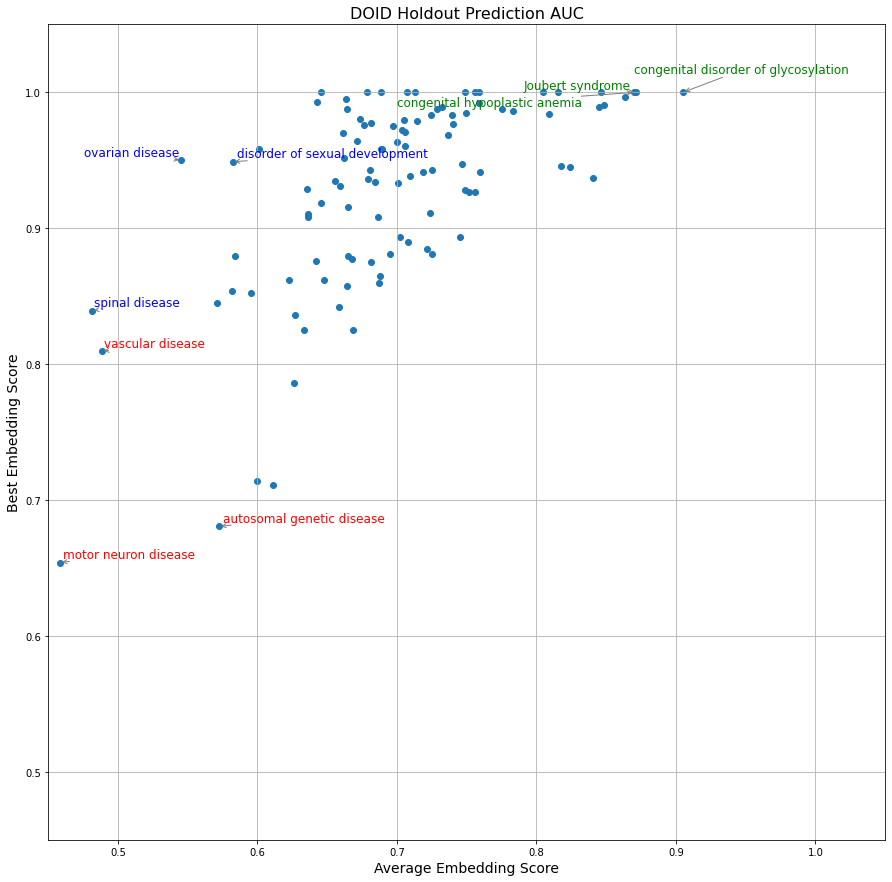

In [288]:
best_embedding_score = holdout_auc_df.max(axis=0)
average_embedding_score = holdout_auc_df.mean(axis=0)
sorted_avg_scores = average_embedding_score.sort_values()
sorted_best_embedding_score = best_embedding_score.sort_values()
combined_scores = (average_embedding_score + best_embedding_score) / 2
final_sorted_scores = combined_scores.sort_values(ascending=False)

top_3_highest = final_sorted_scores.tail(3)
top_3_lowest = final_sorted_scores.head(3)

score_diff = (best_embedding_score - average_embedding_score).abs()
largest_diff_diseases = score_diff.nlargest(3).index

plt.figure(figsize=(15, 15))

plt.xlim(0.45, 1.05)
plt.ylim(0.45, 1.05)

plt.scatter(average_embedding_score, best_embedding_score)

texts = []
for disease in top_3_lowest.index:
    x, y = average_embedding_score[disease], best_embedding_score[disease]
    texts.append(plt.text(x, y, disease, fontsize=12, color='green'))

for disease in top_3_highest.index:
    x, y = average_embedding_score[disease], best_embedding_score[disease]
    texts.append(plt.text(x, y, disease, fontsize=12, color='red'))

for disease in largest_diff_diseases:
    x, y = average_embedding_score[disease], best_embedding_score[disease]
    texts.append(plt.text(x, y, disease, fontsize=12, color='blue'))

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))

plt.ylabel("Best Embedding Score", fontsize=14)  # Adjust fontsize as needed
plt.xlabel("Average Embedding Score", fontsize=14)  # Adjust fontsize as needed
plt.title("DOID Holdout Prediction AUC", fontsize=16)
plt.grid(True)

plt.savefig("plots/omim_holdout.pdf", format="pdf", bbox_inches="tight")

plt.show()


In [296]:
test_data = df_summary_with_meta.copy()

test_data['Dimension_2'] = test_data['Original Dimensions'].apply(lambda x: x[1])


model = smf.ols('holdout_auc ~ Category + Method + Dimension_2', data=test_data).fit()
#print(model.summary())
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)


def calculate_anova_with_ratios(dependent_variable, data):
    print(f"\nANOVA for {dependent_variable}")
    model = smf.ols(f'{dependent_variable} ~ Method + Category + Dimension_2', data=data).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    
    total_sum_sq = anova_table["sum_sq"].sum()
    anova_table["ratio"] = anova_table["sum_sq"] / total_sum_sq
    
    print(anova_table)
    return anova_table

calculate_anova_with_ratios("holdout_auc", test_data)


               sum_sq    df          F        PR(>F)
Category     0.066536   5.0  15.412730  6.018851e-07
Method       0.021940   5.0   5.082143  2.379885e-03
Dimension_2  0.000464   2.0   0.268671  7.665739e-01
Residual     0.021585  25.0        NaN           NaN

ANOVA for holdout_auc
               sum_sq    df          F        PR(>F)     ratio
Method       0.021940   5.0   5.082143  2.379885e-03  0.198503
Category     0.066536   5.0  15.412730  6.018851e-07  0.602005
Dimension_2  0.000464   2.0   0.268671  7.665739e-01  0.004198
Residual     0.021585  25.0        NaN           NaN  0.195295


,sum_sq,df,F,PR(>F),ratio
Method,0.021940,5.0,5.082143,2.379885e-03,0.198503
Category,0.066536,5.0,15.412730,6.018851e-07,0.602005
Dimension_2,0.000464,2.0,0.268671,7.665739e-01,0.004198
Residual,0.021585,25.0,NaN,NaN,0.195295


In [292]:
def plot_slim_clustermap3(
    df,
    graph=graph,
    filtered_doid_to_slim=filtered_doid_to_slim,
    meta_file_path='z_benchmark_embed_meta.csv',
    figsize=(25, 15),
    cmap='viridis',
    title='Fold AUC',
    legend=False
):
 

    doid_to_name = {
        node: data.get('name')
        for node, data in graph.nodes(data=True)
        if 'name' in data
    }

    max_slims = max(len(slims) for slims in filtered_doid_to_slim.values()) if filtered_doid_to_slim else 0
    all_slims = {
        slim_term
        for slim_list in filtered_doid_to_slim.values()
        for slim_term in slim_list
    }
    slim_palette = sns.color_palette("hls", len(all_slims))
    slim_color_dict = dict(zip(all_slims, slim_palette))

    WHITE = "#ffffff"

    columns = df.columns
    col_colors_df = pd.DataFrame(index=columns, columns=range(max_slims), dtype=object)
    for col in columns:
        slims_for_go = filtered_doid_to_slim.get(col, [])
        for i in range(max_slims):
            if i < len(slims_for_go):
                slim_term = slims_for_go[i]
                col_colors_df.at[col, i] = slim_color_dict[slim_term]
            else:
                col_colors_df.at[col, i] = WHITE

    col_colors_df = col_colors_df.iloc[:, ::-1].T

    renamed_cols = [doid_to_name.get(doid, doid) for doid in df.columns]
    df.columns = renamed_cols
    col_colors_df.columns = renamed_cols
    col_colors_df = col_colors_df.T

    meta_df = pd.read_csv(meta_file_path, index_col=0, encoding='utf-8')
    meta_df.index = meta_df.index.str.replace(r'\s+', '', regex=True)

    row_categories = meta_df.loc[df.index, 'Category']
    cat_color_dict = {
        'gene expression (bulk)': "#920015",
        'gene expression (single cell)': "#ef476f",
        'amino acid sequence': "#ffd166",
        'PPI': "#06d6a0",
        'biomedical literature': "#118ab2",
        'mutation profile, biomedical literature, PPI': "#073b4c"
    }
    row_colors = row_categories.map(cat_color_dict)

    g = sns.clustermap(
        df,
        cmap=cmap,
        annot=False,
        fmt=".4f",
        figsize=figsize,
        row_colors=row_colors,
        cbar_kws={
            "shrink": 0.6,
            "aspect": 20,
            "pad": 0.02
        }
    )
    
    row_order = g.dendrogram_row.reordered_ind
    col_order = g.dendrogram_col.reordered_ind
    reordered_row_labels = df.index[row_order]
    reordered_col_labels = df.columns[col_order]

    g.ax_heatmap.set_xticks(range(len(reordered_col_labels)))
    g.ax_heatmap.set_xticklabels(reordered_col_labels, rotation=90, fontsize=12)

    g.ax_heatmap.set_yticks(range(len(reordered_row_labels)))
    g.ax_heatmap.set_yticklabels(reordered_row_labels, fontsize=12)

    g.fig.suptitle(title, fontsize=16)
    g.fig.subplots_adjust(top=0.9)
    g.ax_heatmap.set_xlabel('DOID Terms', fontsize=14)
    g.ax_heatmap.set_ylabel('Embeddings', fontsize=14)

    plt.savefig(f"plots/omim/{title}_clustermap.pdf", format="pdf", bbox_inches="tight")

    df_melted = df.reset_index().melt(
        id_vars='index', 
        var_name='DOID', 
        value_name=title
    )
    df_melted.rename(columns={'index': 'Embedding'}, inplace=True)
    df_melted = df_melted.merge(
        meta_df[['Category']], 
        left_on='Embedding', 
        right_index=True,
        how='left'
    )

    plt.figure(figsize=(5, 10))
    sns.boxplot(
        data=df_melted,
        x=title,
        y='Embedding',
        hue='Category',
        palette=cat_color_dict,
        width=.5,
        dodge=False,
        showfliers=True
    )

    if legend:
        plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        plt.legend('', frameon=False)

    plt.savefig(f"plots/omim/{title}_boxplot.pdf", format="pdf", bbox_inches="tight")

    return g

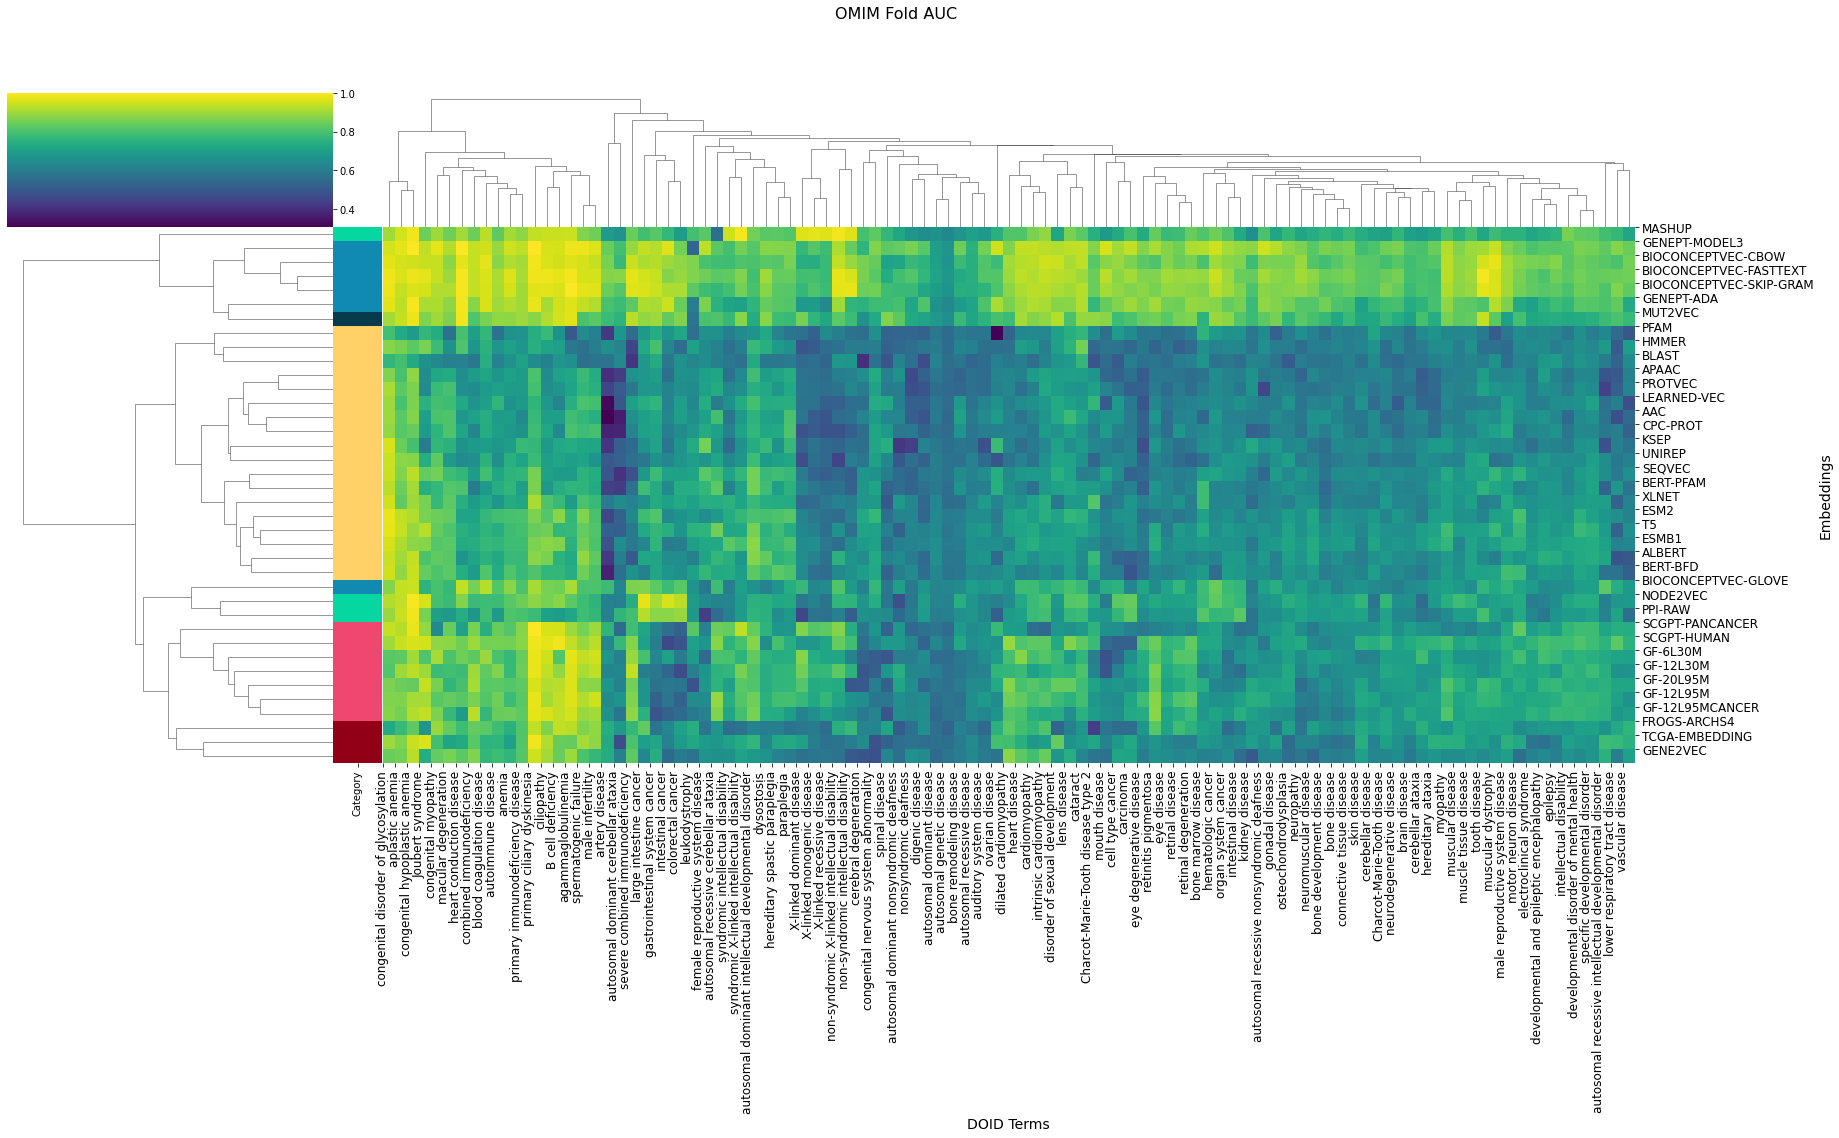

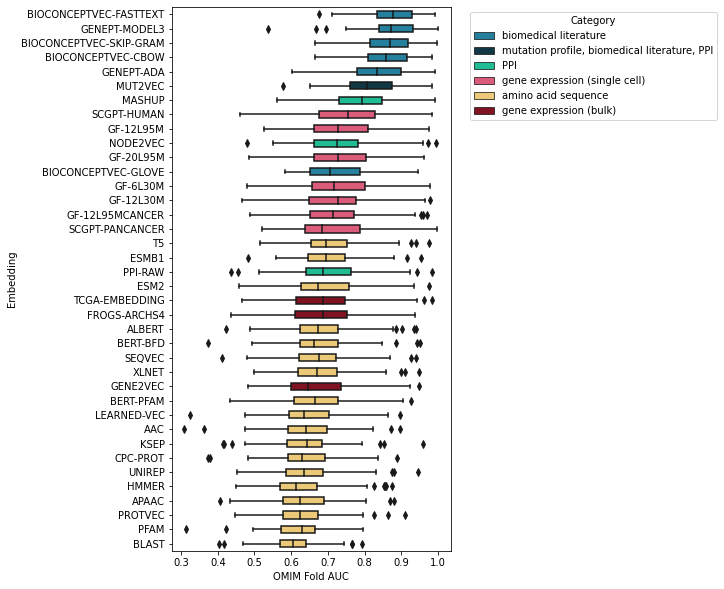

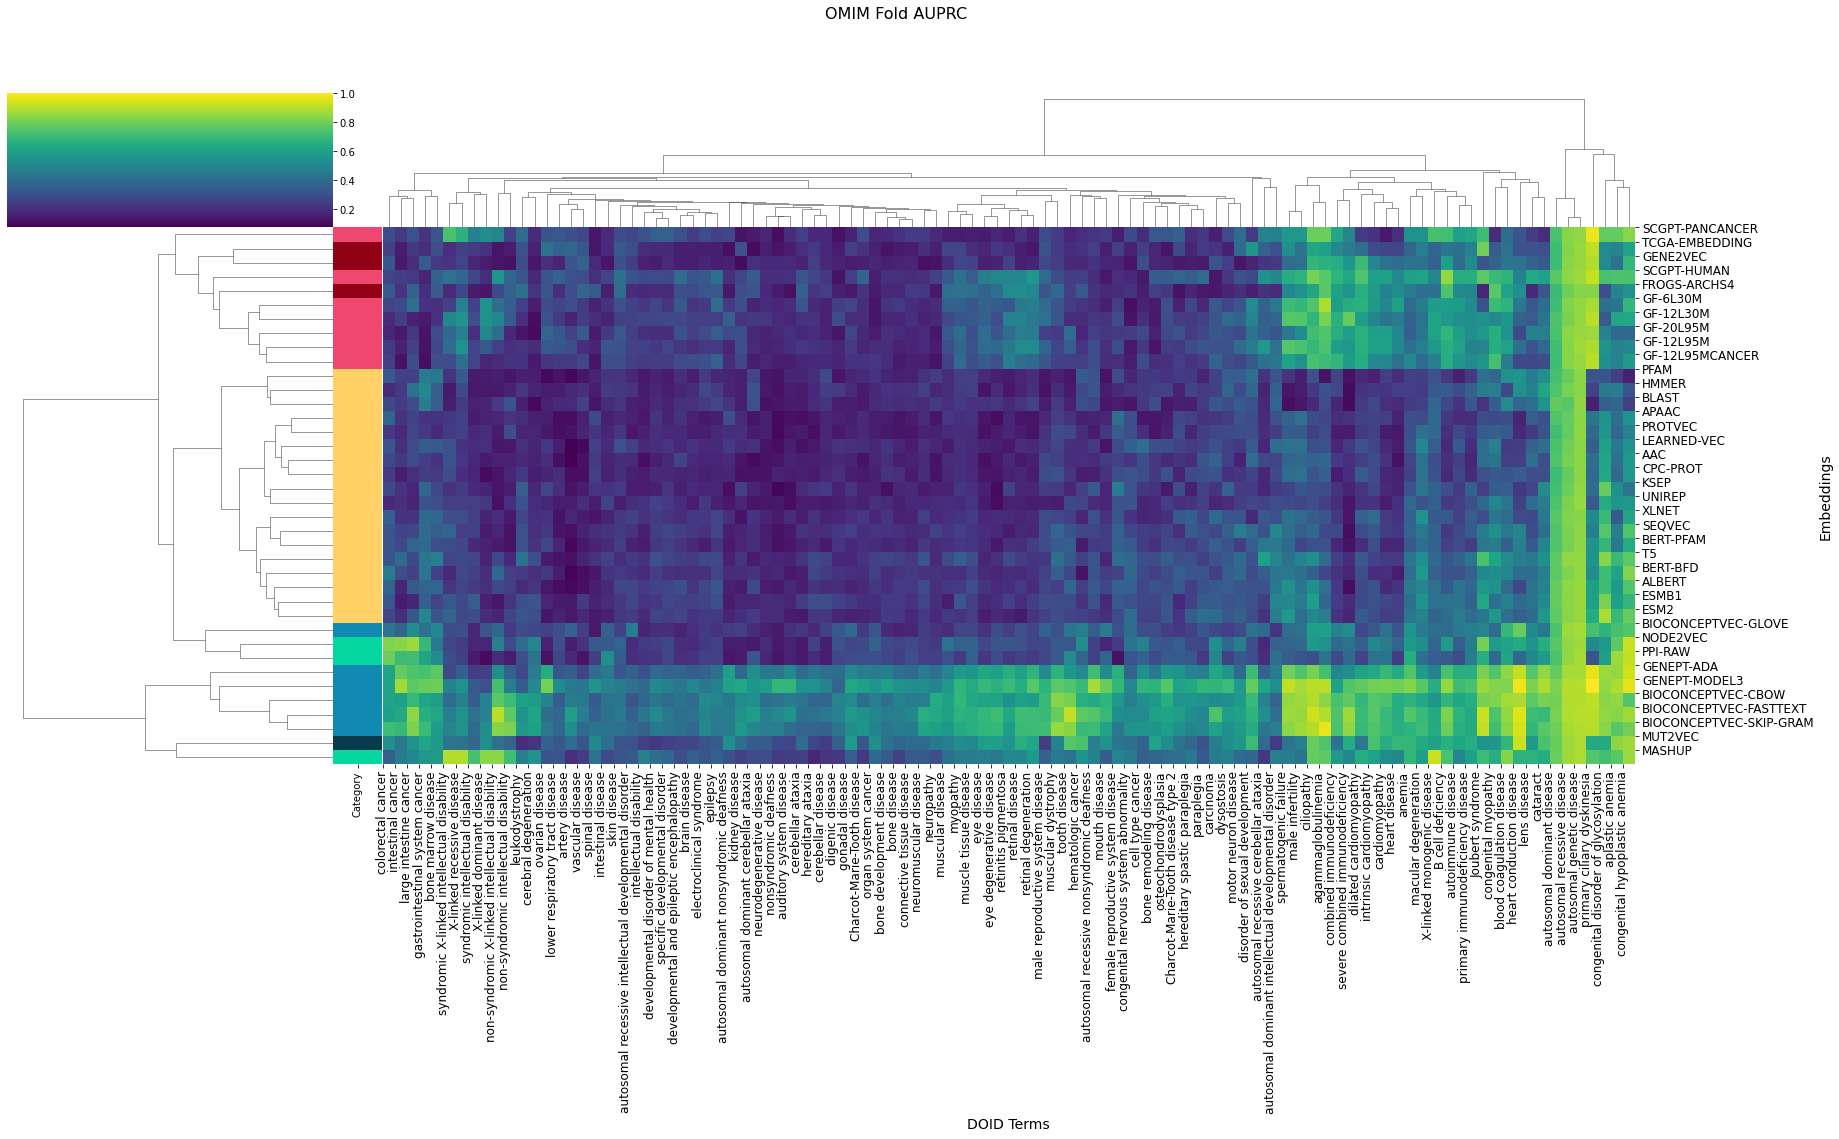

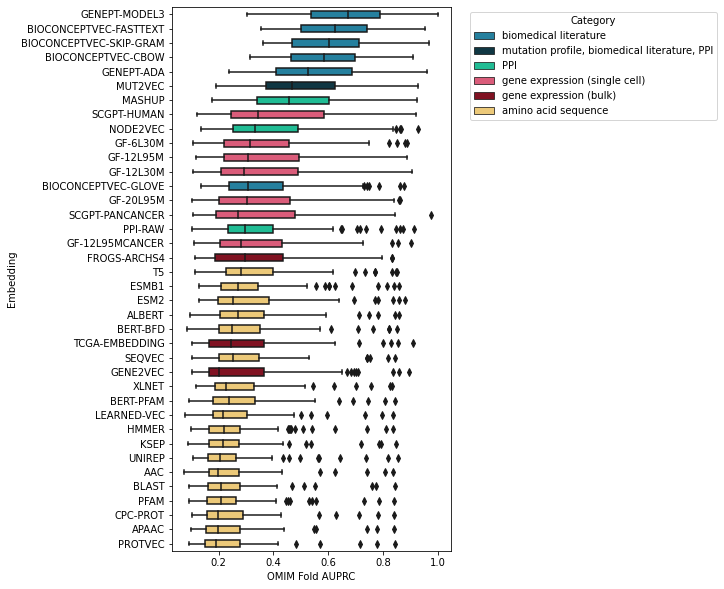

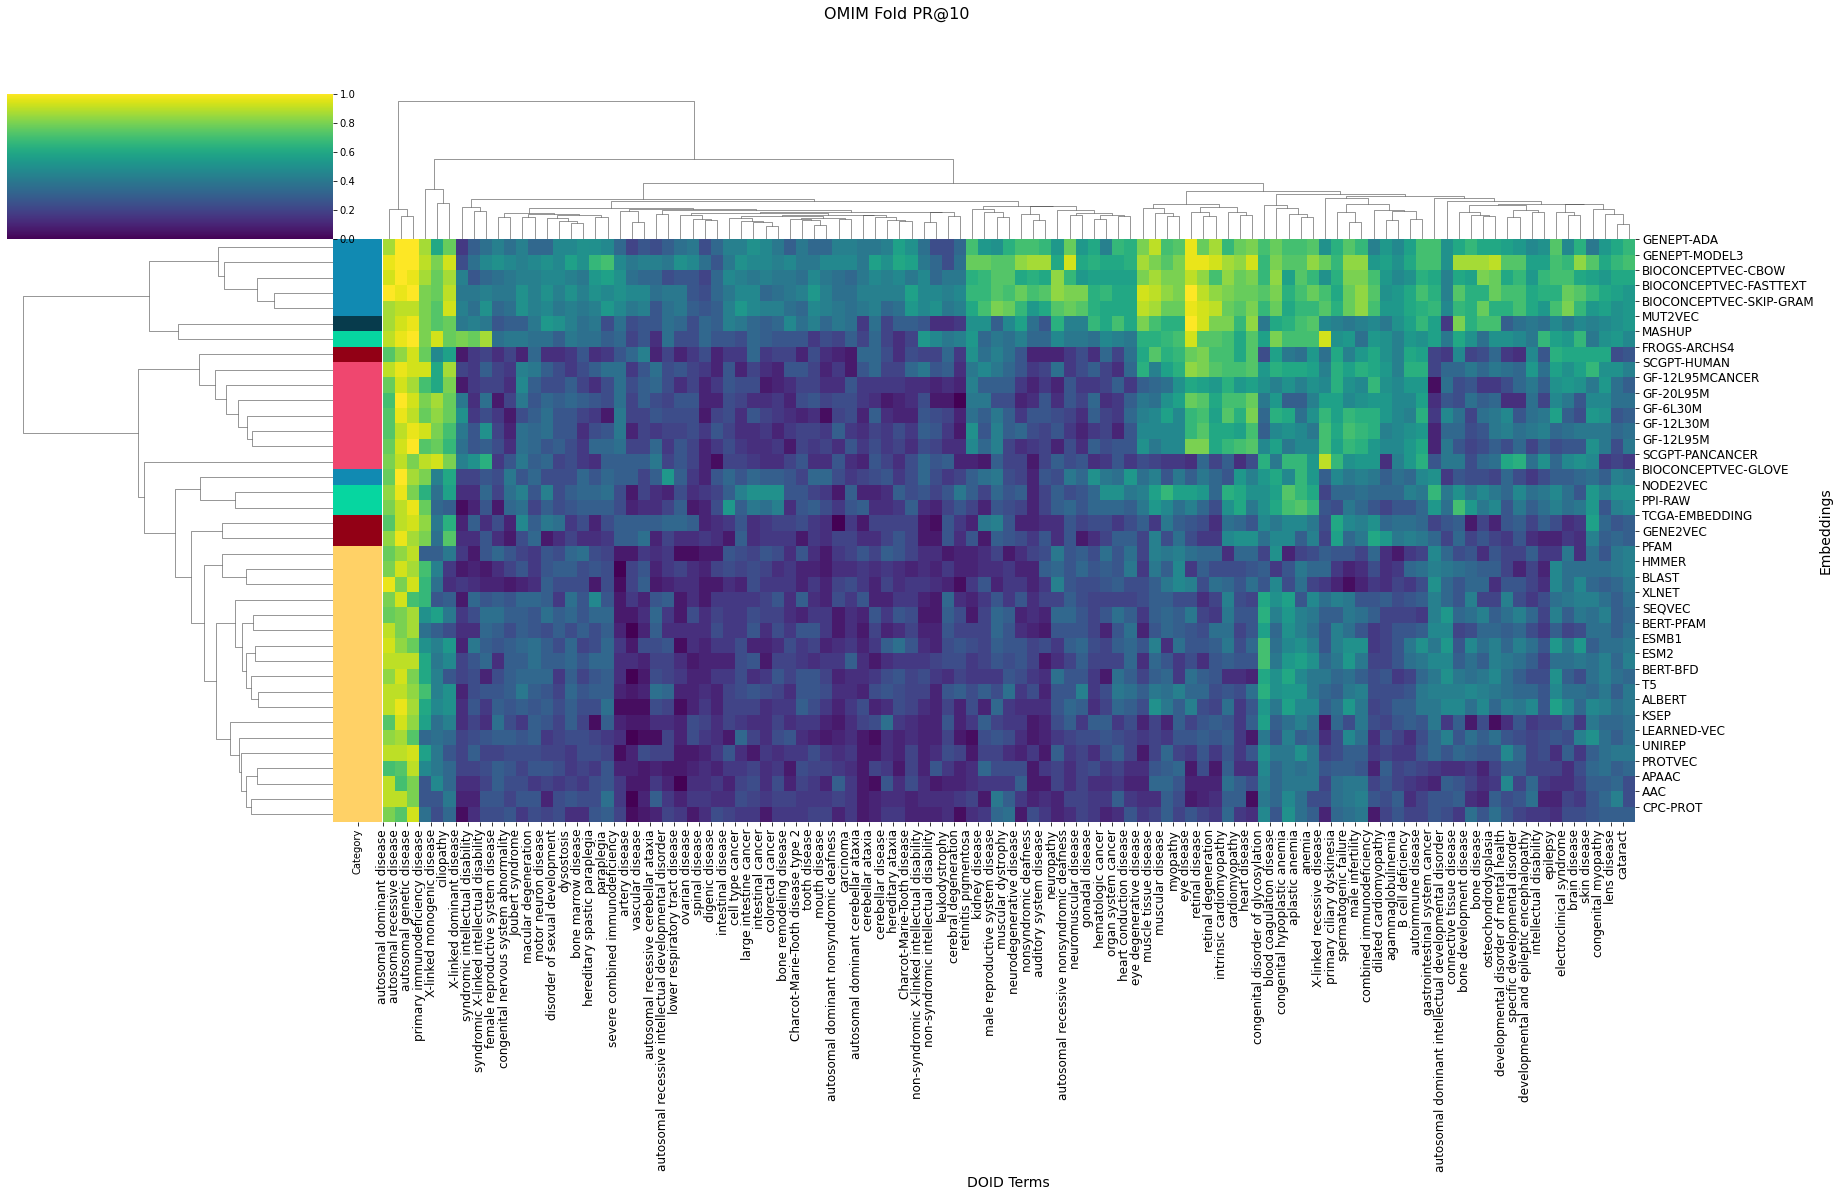

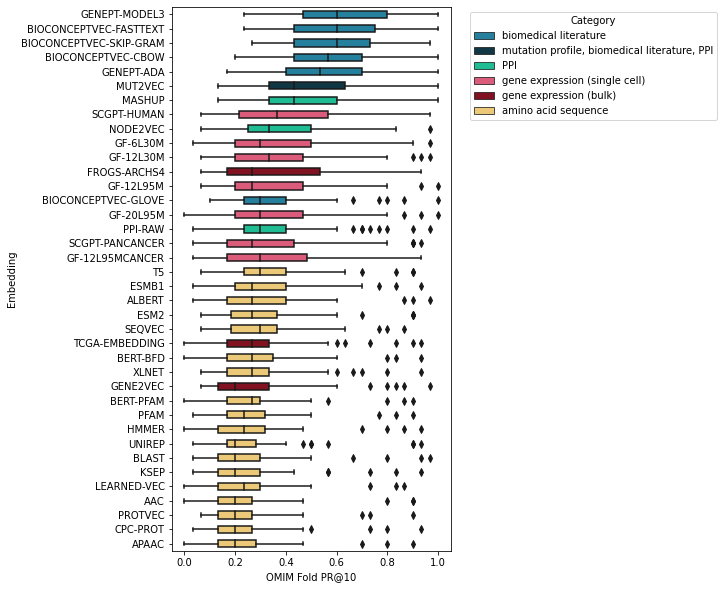

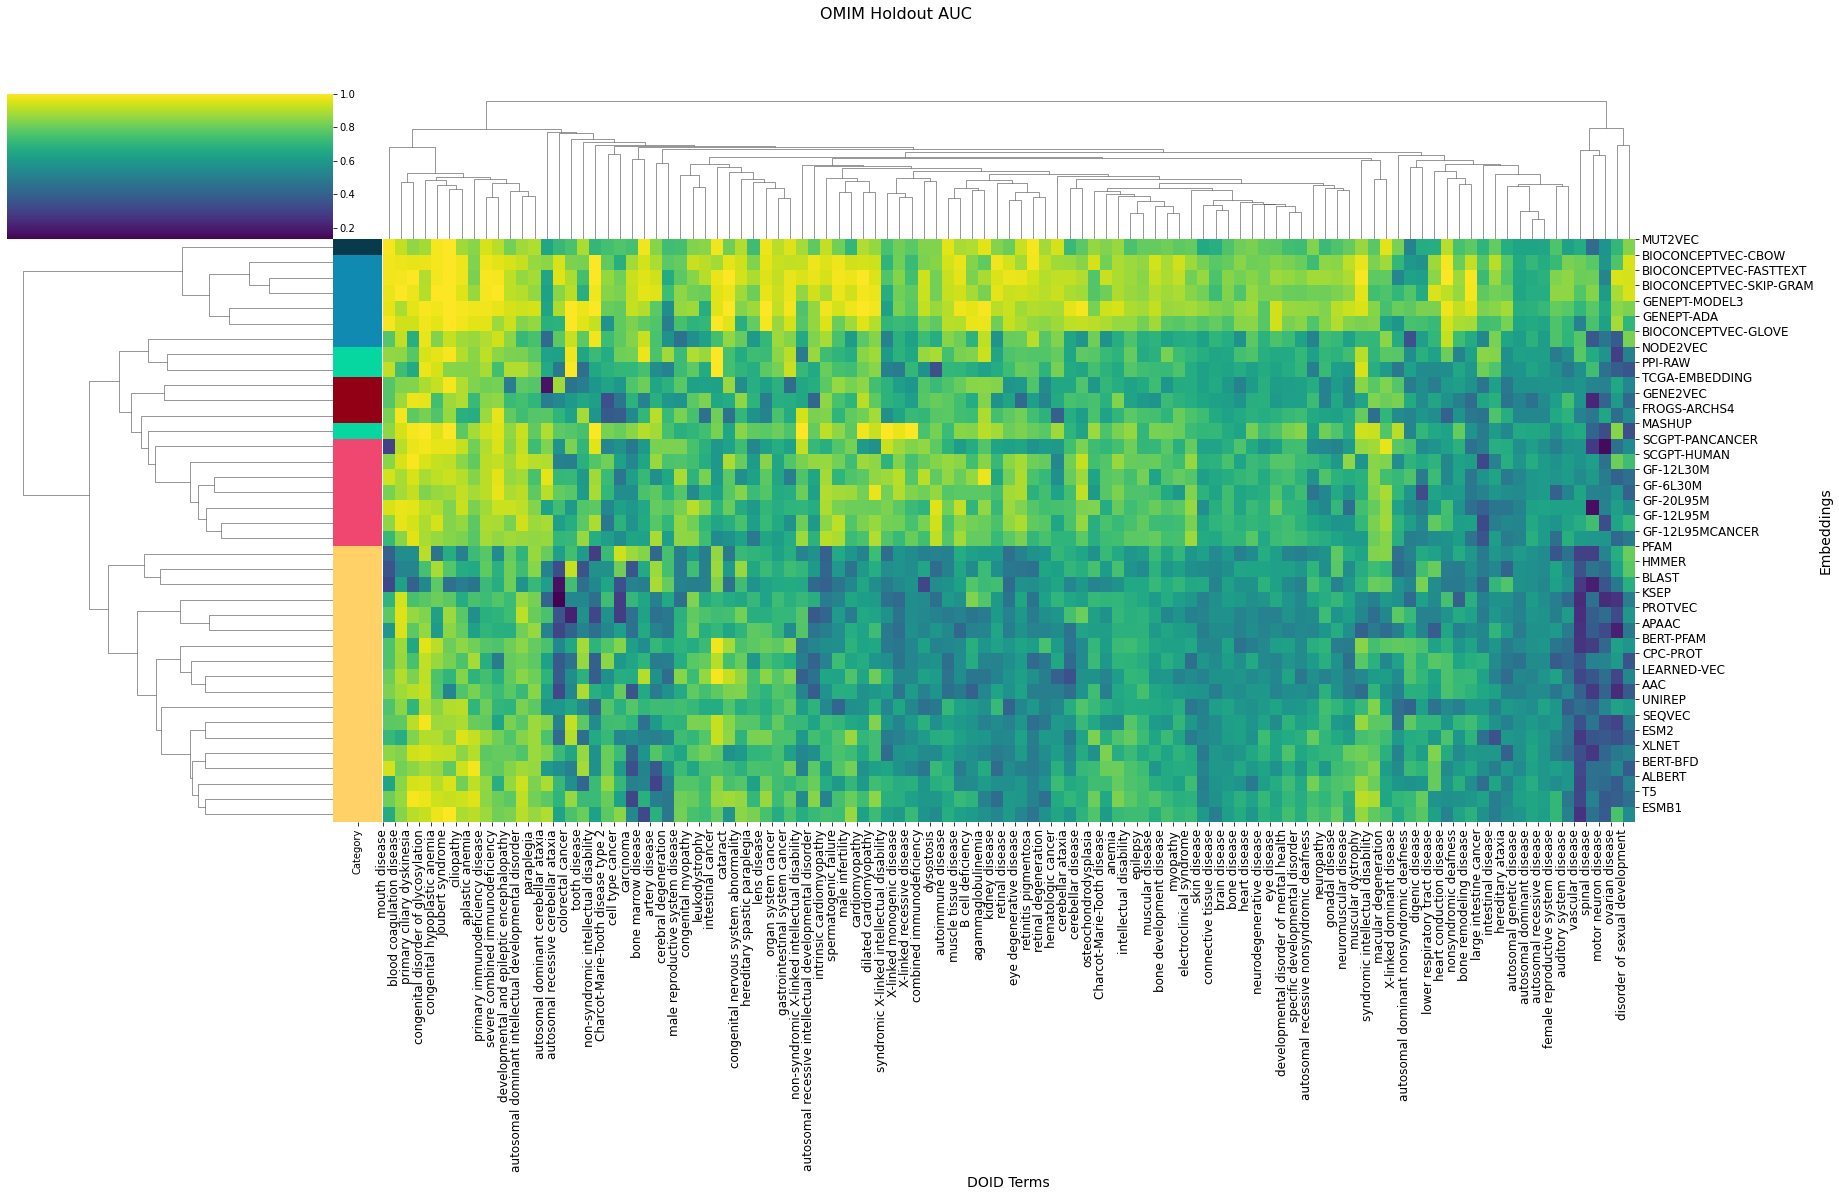

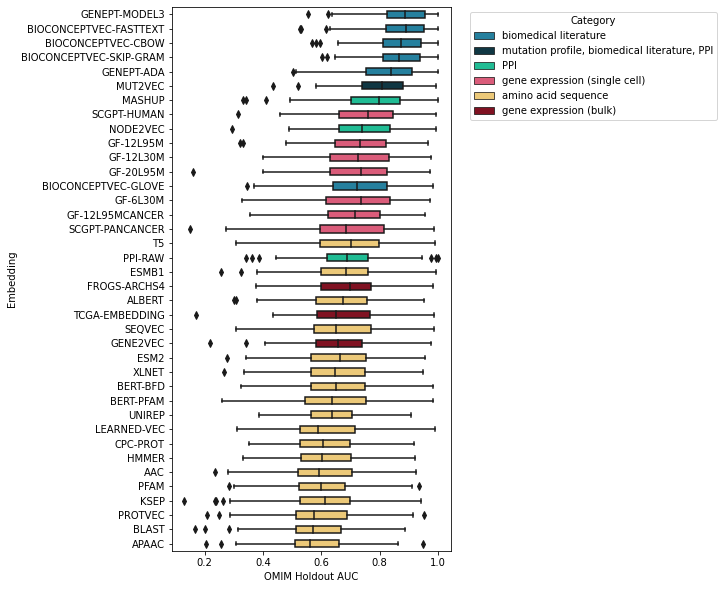

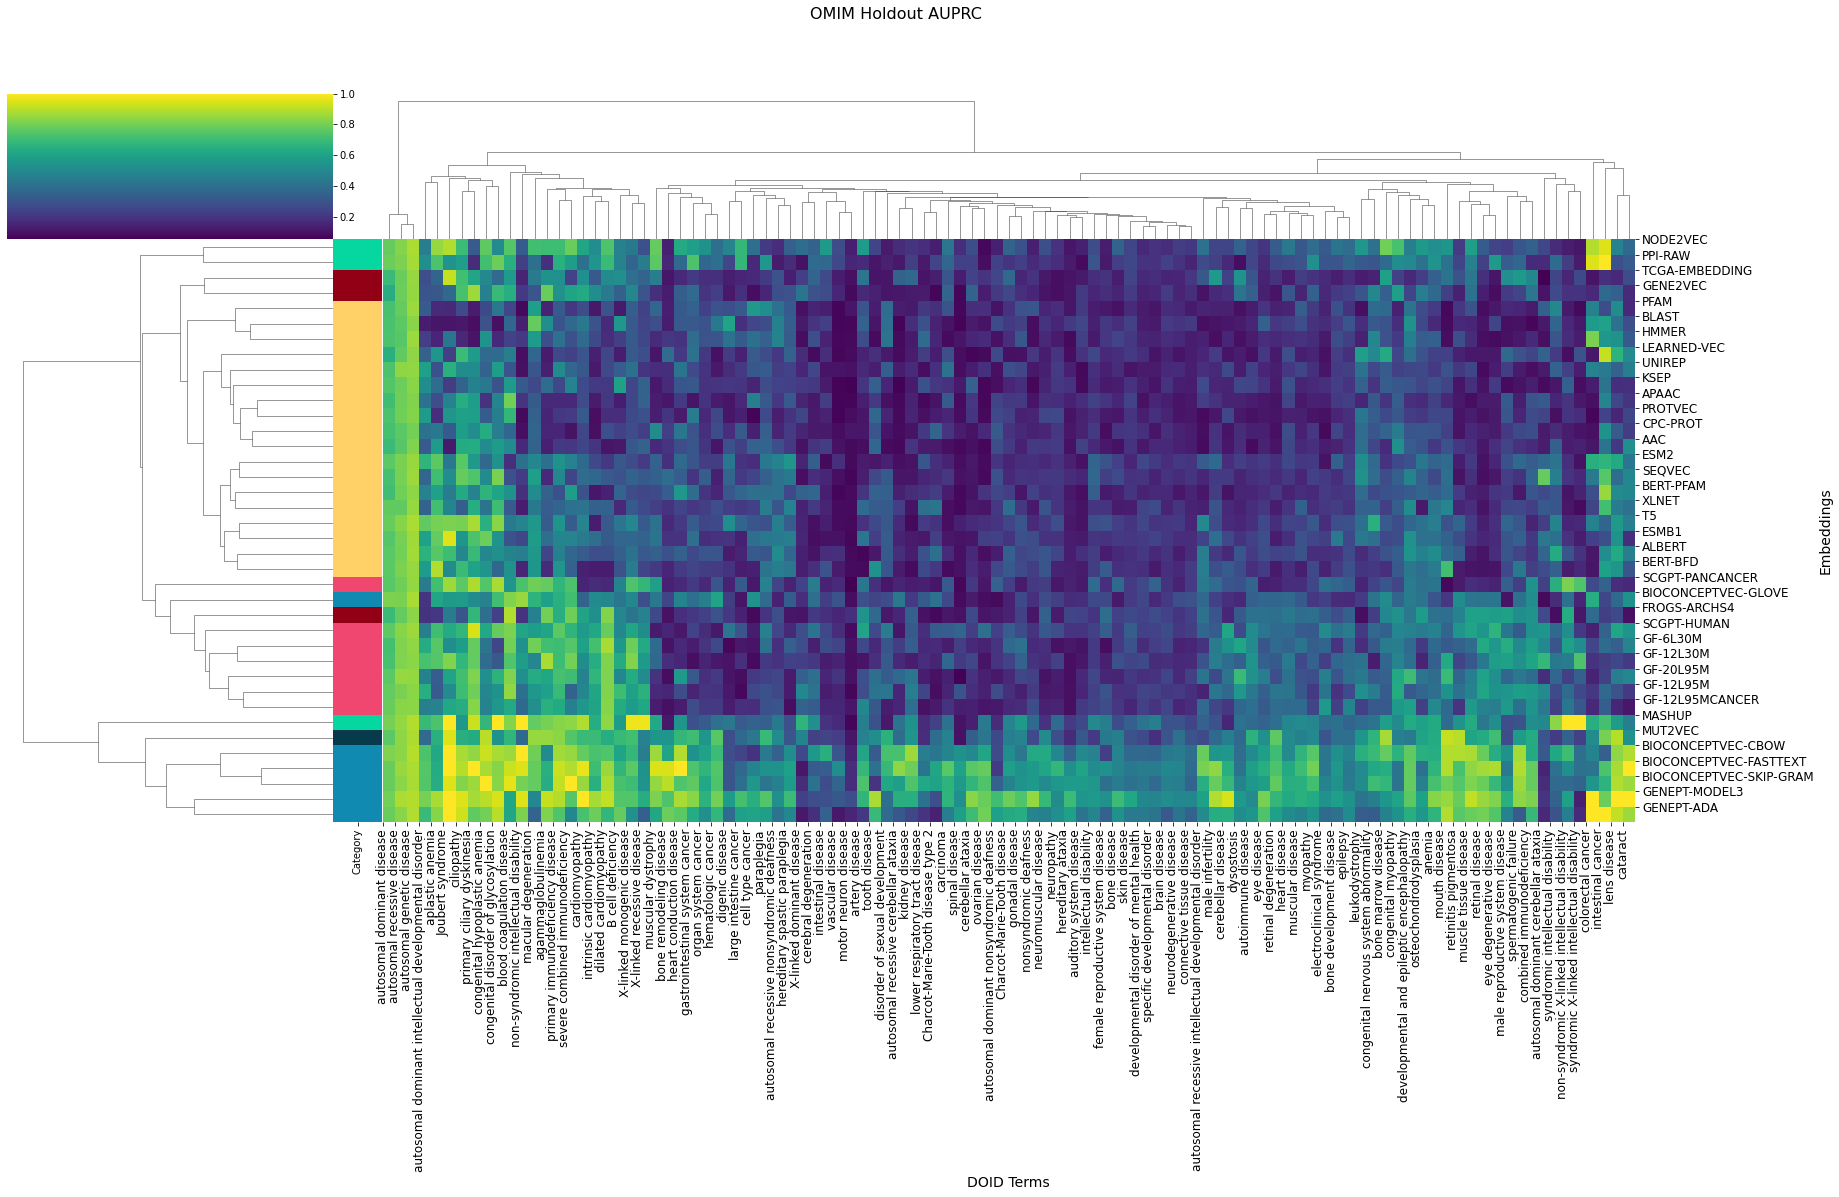

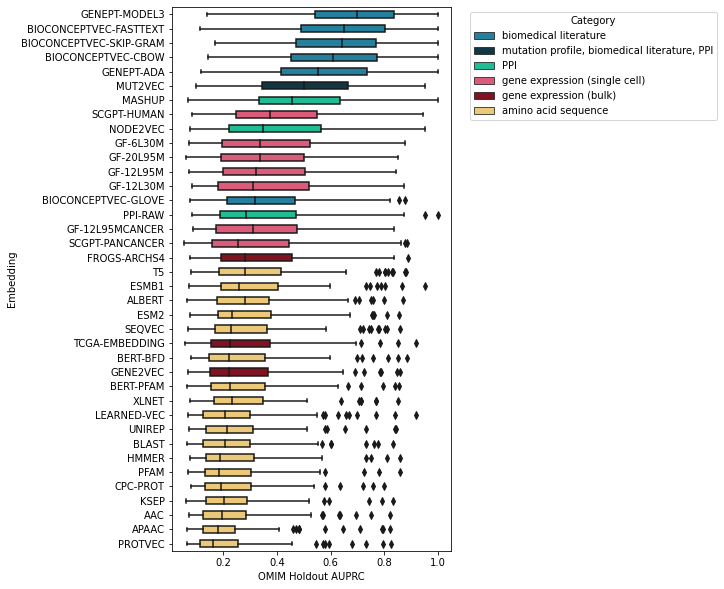

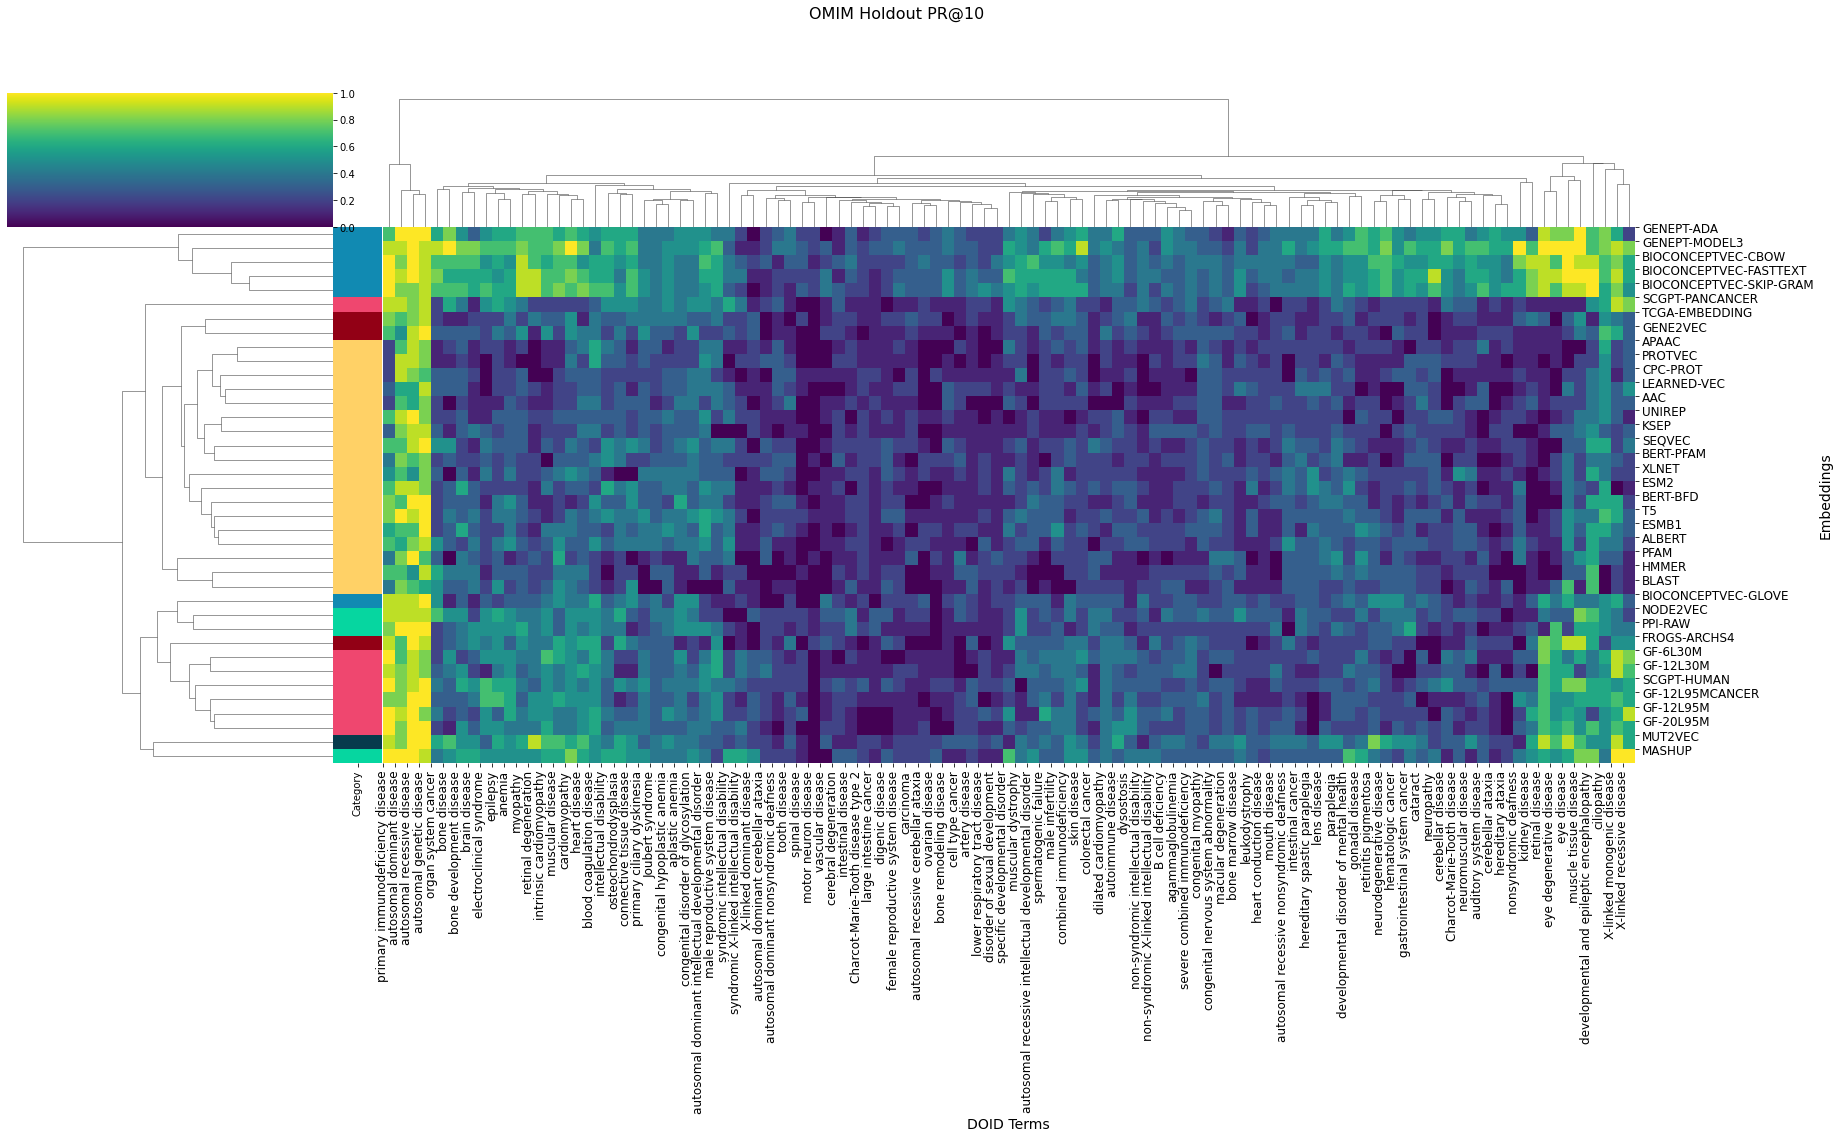

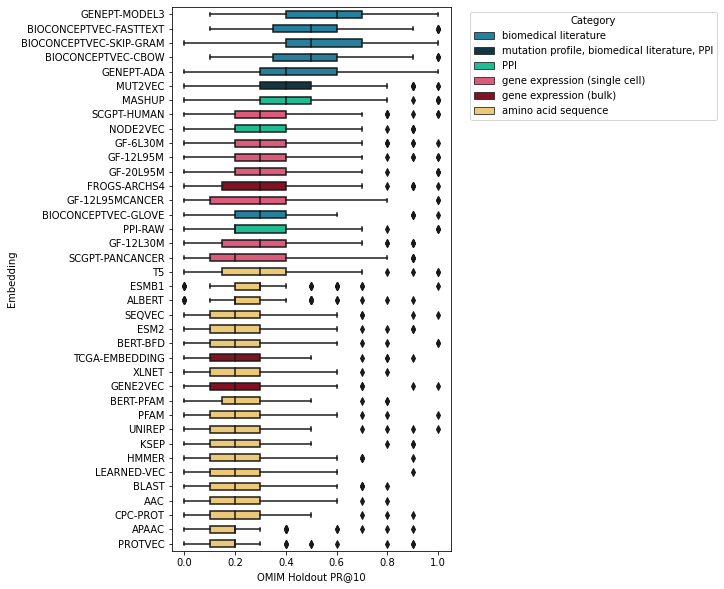

In [293]:
g = plot_slim_clustermap3(
    df=fold_auc_df.loc[fold_auc_df.mean(axis=1).sort_values(ascending=False).index],
    title = 'OMIM Fold AUC',
    legend= True 
)

g = plot_slim_clustermap3(
    df=fold_auprc_df.loc[fold_auprc_df.mean(axis=1).sort_values(ascending=False).index],
    title = 'OMIM Fold AUPRC',
    legend= True 
)

g = plot_slim_clustermap3(
    df=fold_pr10_df.loc[fold_pr10_df.mean(axis=1).sort_values(ascending=False).index],
    title = 'OMIM Fold PR@10',
    legend= True 
)


g = plot_slim_clustermap3(
    df=holdout_auc_df.loc[holdout_auc_df.mean(axis=1).sort_values(ascending=False).index],
    title = 'OMIM Holdout AUC',
    legend= True 
)

g = plot_slim_clustermap3(
    df=holdout_auprc_df.loc[holdout_auprc_df.mean(axis=1).sort_values(ascending=False).index],
    title = 'OMIM Holdout AUPRC',
    legend= True 
)

g = plot_slim_clustermap3(
    df=holdout_pr10_df.loc[holdout_pr10_df.mean(axis=1).sort_values(ascending=False).index],
    title = 'OMIM Holdout PR@10',
    legend= True 
)